## Import Libraries and Load the Dataset

In [76]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


# Load the data
file_path = "C:/Users/salin/OneDrive/Desktop/DSC630 Predictive Analytics\Term Project Milestones/HospitalFinancialData21-22.xlsx"
data = pd.read_excel(file_path)


## Data Inspection

In [77]:
# Display the columns to get an overview of all available metrics
data.columns

# Display the first few rows of the dataframe
print(data.head())

   Unnamed: 0.1  Unnamed: 0  Facility_ID                 Hospital_Name  \
0             0           0    106580996  ADVENTIST HEALTH AND RIDEOUT   
1             1           1    106150788  ADVENTIST HEALTH BAKERSFIELD   
2             2           2    106171049    ADVENTIST HEALTH CLEARLAKE   
3             3           3    106150706       ADVENTIST HEALTH DELANO   
4             4           4    106190323     ADVENTIST HEALTH GLENDALE   

  Financial_Year_Start Financial_Year_End  Reporting_Period Data_Indicator  \
0           2021-01-01         2021-12-31               365     In Process   
1           2021-01-01         2021-12-31               365        Audited   
2           2021-01-01         2021-12-31               365        Audited   
3           2021-01-01         2021-12-31               365        Audited   
4           2021-01-01         2021-12-31               365        Audited   

         Audit_Indicator  County_Name  ...  PRD_HR_ADM  PRD_HR_NON PD_HR_DLY  \
0  Inc

In [78]:
# Check for missing values
missing_values = data.isnull().sum()

# Summary statistics for numerical columns
summary_statistics = data.describe()

print(missing_values)



Unnamed: 0.1            0
Unnamed: 0              0
Facility_ID             0
Hospital_Name           0
Financial_Year_Start    0
                       ..
PD_HR_ED                0
PD_HR_GEN               0
PD_HR_FIS               0
PD_HR_ADM               0
PD_HR_NON               0
Length: 248, dtype: int64


## Filter Out Hospitals Without ER Visits

In [79]:
# Filter out hospitals without ER visits
data_with_er = data[data['VIS_ER'] > 0]

## Summary Statistics

In [80]:
# Summary statistics and distribution plot for ER visits
er_visits_summary = data_with_er['VIS_ER'].describe()

print(er_visits_summary)


count       308.000000
mean      45540.253247
std       33430.295777
min          10.000000
25%       21122.250000
50%       39003.500000
75%       62434.500000
max      222110.000000
Name: VIS_ER, dtype: float64


## Feature Exploration
Exploring correlations between variables:

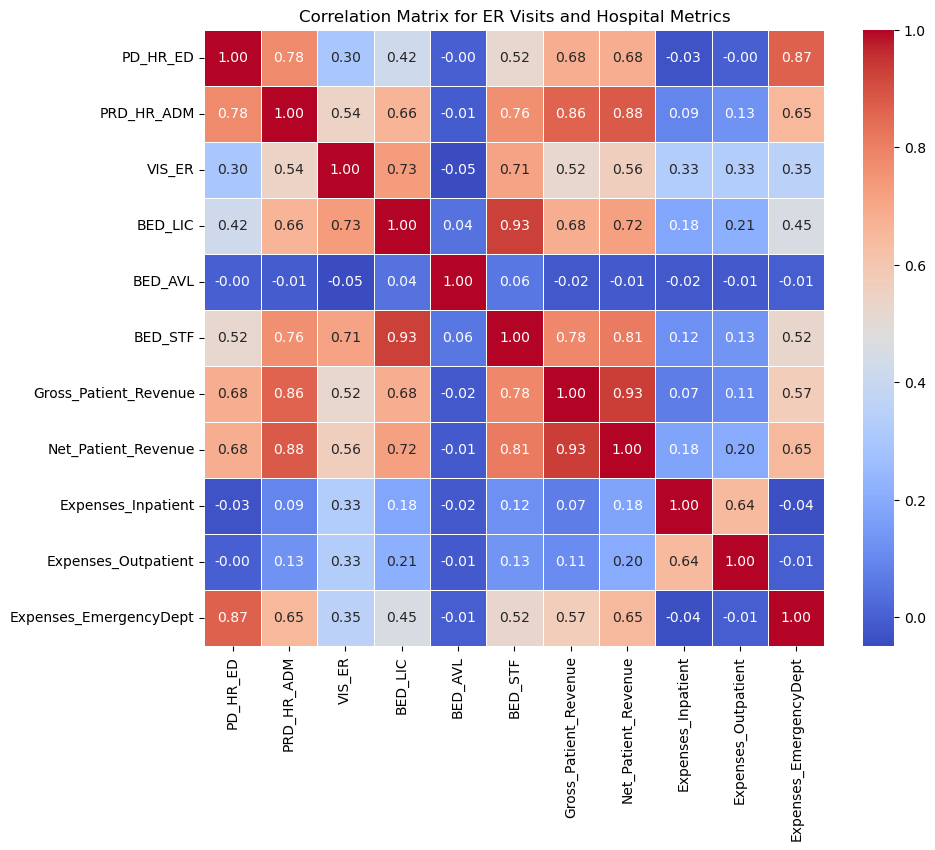

In [81]:
# Selecting relevant columns for correlation analysis
correlation_columns = ['PD_HR_ED', 'PRD_HR_ADM', 'VIS_ER', 'BED_LIC', 'BED_AVL', 'BED_STF', 
                       'Gross_Patient_Revenue', 'Net_Patient_Revenue', 
                       'Expenses_Inpatient', 'Expenses_Outpatient', 'Expenses_EmergencyDept']

# Creating a subset for correlation analysis
correlation_data = data_with_er[correlation_columns]

# Calculating correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for ER Visits and Hospital Metrics')
plt.show()


## Visualization
Visualizing the relationships and distributions of data:

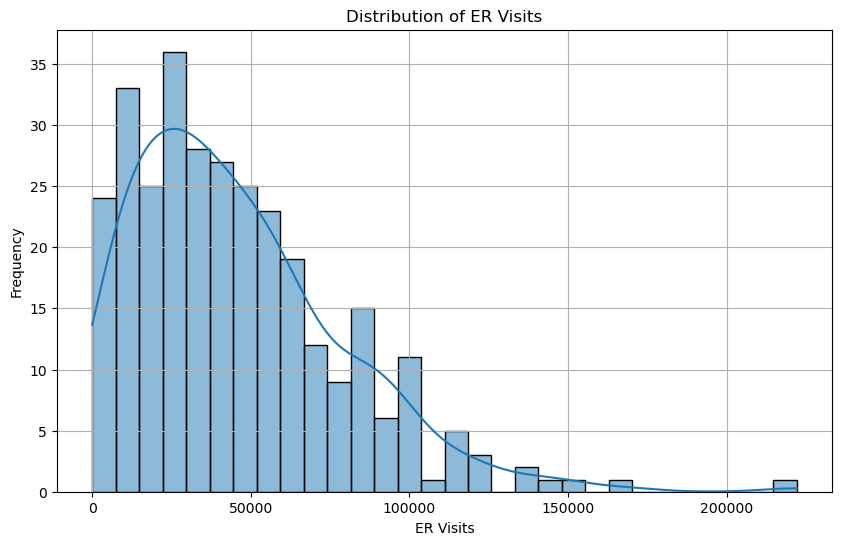

Text(0, 0.5, 'Net_Patient_Revenue')

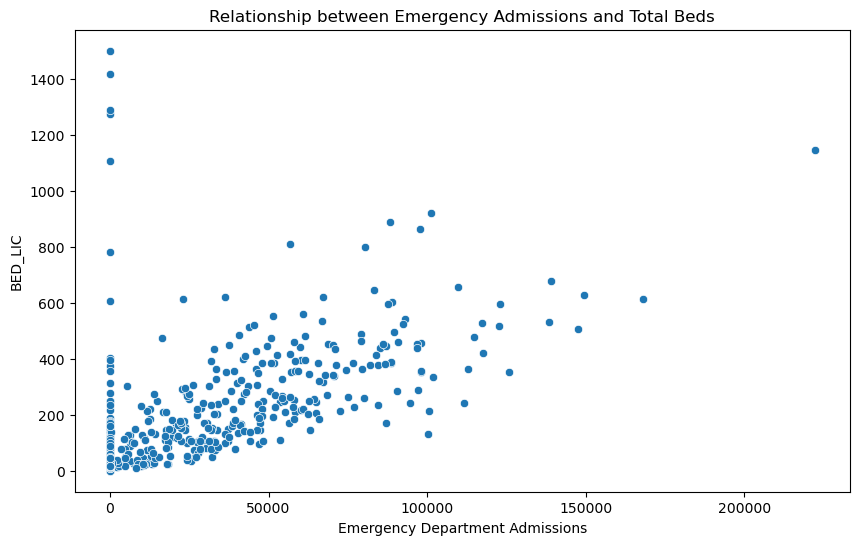

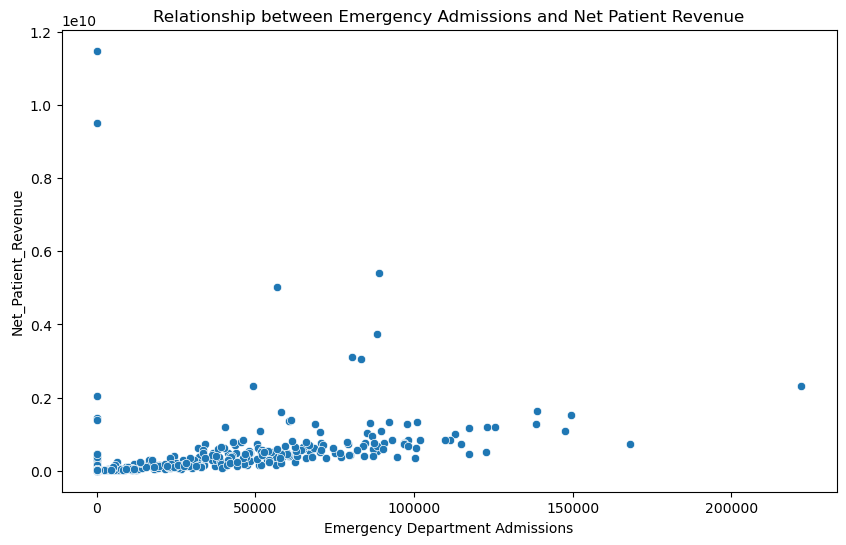

In [82]:
# Histogram of emergency department admissions
plt.figure(figsize=(10, 6))
sns.histplot(data_with_er['VIS_ER'], bins=30, kde=True)
plt.title('Distribution of ER Visits')
plt.xlabel('ER Visits')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Scatter plot between emergency department admissions and another variable
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['VIS_ER'], y=data['BED_LIC'])
plt.title('Relationship between Emergency Admissions and Total Beds')
plt.xlabel('Emergency Department Admissions')
plt.ylabel('BED_LIC')

# Scatter plot between emergency department admissions and Net Patient Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['VIS_ER'], y=data['Net_Patient_Revenue'])
plt.title('Relationship between Emergency Admissions and Net Patient Revenue')
plt.xlabel('Emergency Department Admissions')
plt.ylabel('Net_Patient_Revenue')


## Data Preparation for Modeling

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preparing data for modeling
X = correlation_data.drop(['VIS_ER'], axis=1)
y = correlation_data['VIS_ER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Randon Forest Model

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Training Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

# Prediction and evaluation
y_pred_test_rf = random_forest_model.predict(X_test_scaled)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print(f"MSE Test: {mse_test_rf}, R2 Test: {r2_test_rf}")


MSE Test: 381931702.5612355, R2 Test: 0.6568538280263421


## Feature Importance Analysis from Random Forest

In [85]:
# Extracting feature importances
feature_importances = random_forest_model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print(features_df)


                  Feature  Importance
6     Net_Patient_Revenue    0.497804
5   Gross_Patient_Revenue    0.230129
3                 BED_AVL    0.068467
2                 BED_LIC    0.053595
1              PRD_HR_ADM    0.042668
4                 BED_STF    0.041443
7      Expenses_Inpatient    0.020191
9  Expenses_EmergencyDept    0.017056
0                PD_HR_ED    0.015911
8     Expenses_Outpatient    0.012735


Suppressing stdout and stderr Output

In [86]:
import os
import sys
from contextlib import contextmanager

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

## Model Optimization
Hyperparameter Tuning with GridSearchCV

In [87]:
!pip install lightgbm
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 5, 10, 20],  # -1 means no limit
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

# Initialize the model
lgbm = LGBMRegressor(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Use the suppress_stdout_stderr context manager to mute the fitting process
with suppress_stdout_stderr():
    grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)


Best parameters found:  {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}
Best score found:  -419703446.35472023


## Validation Curves

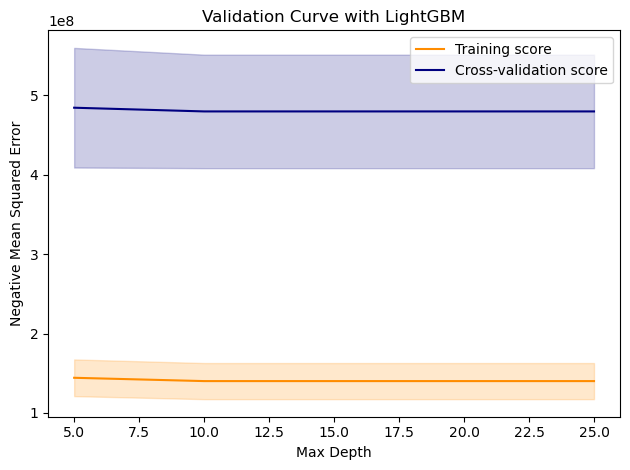

In [88]:
from sklearn.model_selection import validation_curve

# Define the range of the parameter
param_range = [5, 10, 15, 20, 25]

# Calculate scores for training and test sets
train_scores, test_scores = validation_curve(
    LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31, random_state=42),
    X_train_scaled, y_train, param_name="max_depth", param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
plt.plot(param_range, train_mean, label="Training score", color="darkorange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="darkorange", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.2)

plt.title("Validation Curve with LightGBM")
plt.xlabel("Max Depth")
plt.ylabel("Negative Mean Squared Error")
plt.tight_layout()
plt.legend(loc="best")
plt.show()


## Model Validation
Hold-out Test Set

In [89]:
# Predicting on the test set
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

# Calculating metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R2: {r2}")


Test MSE: 361674983.19146454
Test MAE: 13629.47091262214
Test R2: 0.675053458122163


Cross-Validation

In [90]:
from sklearn.model_selection import cross_val_score

# Use the suppress_stdout_stderr context manager to mute the cross-validation process
with suppress_stdout_stderr():
    
    # Perform cross-validation
    scores = cross_val_score(grid_search.best_estimator_, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Compute the average MSE
average_mse = -scores.mean()
print(f"Average MSE from cross-validation: {average_mse}")


Average MSE from cross-validation: 419703446.35472023


## Feature Selection

In [91]:
# Selecting relevant features based on the correlation analysis
features = ['BED_LIC', 'BED_AVL', 'BED_STF','Gross_Patient_Revenue', 'Net_Patient_Revenue', 
                       'Expenses_Inpatient', 'Expenses_Outpatient', 'Expenses_EmergencyDept']
target = 'VIS_ER'

# Creating the feature matrix (X) and target vector (y)
X = data[features]
y = data[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled and X_test_scaled are ready for modeling


## LightGBM model

In [92]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the LightGBM model with verbosity set to -1 to suppress LightGBM warnings
lgbm_model = LGBMRegressor(random_state=42, verbosity=-1)

# Train the model with the scaled training data
lgbm_model.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = lgbm_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')


Mean Squared Error (MSE): 210694167.46182555
R-squared (R2): 0.6967957293273033


## Model Ensemble with Stacking

In [93]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the base models with LGBMRegressor's verbosity set to -1
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42, verbosity=-1))  # Setting verbosity to -1 to suppress warnings
]

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking ensemble
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the model on the training data
stacked_model.fit(X_train_scaled, y_train)

# Predict and evaluate on the test data
y_pred_stack = stacked_model.predict(X_test_scaled)
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f'Stacked Model MSE: {mse_stack}, R2: {r2_stack}')

Stacked Model MSE: 165694071.68841383, R2: 0.7615541485258361


## Cross-Validation
For cross-validation with the original LightGBM model:

In [94]:
# Reinitialize the LightGBM model for cross-validation
lgbm_cv = LGBMRegressor(random_state=42)

with suppress_stdout_stderr():
    # Perform cross-validation
    cv_scores = cross_val_score(lgbm_cv, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate average MSE
avg_mse_cv = -cv_scores.mean()

print(f'Average MSE from CV: {avg_mse_cv}')

Average MSE from CV: 419941972.8879991


## Hyperparameter tuning for a StackingRegressor model using GridSearchCV
The StackingRegressor combines three base models (RandomForestRegressor, LGBMRegressor, and GradientBoostingRegressor) 
with a LinearRegression model as the final estimator

In [95]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Adding GradientBoostingRegressor for diversity
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]

# Stacking ensemble setup
stacked_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression(), cv=5)

# Define a grid of hyperparameters to search
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'lgbm__num_leaves': [31, 50],
    'lgbm__learning_rate': [0.1, 0.01],
    'gbr__n_estimators': [100, 200],
    'gbr__learning_rate': [0.1, 0.01]
}

with suppress_stdout_stderr():
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=stacked_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    # Fit GridSearchCV
    grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Best parameters: {'gbr__learning_rate': 0.01, 'gbr__n_estimators': 200, 'lgbm__learning_rate': 0.1, 'lgbm__num_leaves': 31, 'rf__max_depth': 10, 'rf__n_estimators': 100}
Best score: 377519278.44106954


## Evaluate the Performance of the Optimized Stacking Regressor Model on Test Dataset

In [96]:
# Predicting on the test set
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Test MSE: {mse}")
print(f"Test R2: {r2}")


Test MSE: 148943417.71257594
Test R2: 0.7856595610449314
